## 2020-07-27: Exploring Bayesian Optimization

*Last Updated*: 2020-07-28

### Authors
* Kevin Chu (kevin@velexi.com)

### Overview
In this Jupyter notebook, we explore Bayesian optimization.

* The Gaussian process in the example uses the Matern kernel, which is a generalization
  of the RBF kernel.

### User parameters

#### Objective Function
* `domain`: domain for objective function
* `f`: objective function

#### Observation Parameters
* `noise`: noise level

#### Bayesian optimization parameters
* `X_init`: initial observations
* `num_iterations`: number of Bayesian optimization iterations
* `xi` (OPTIONAL): exploitation-exploration trade-off parameter

### Acknowledgements
* The example in this notebook is based on the following blog article.
    * M. Krasser "Bayesian optimization" (2018)
        * https://krasserm.github.io/2018/03/21/bayesian-optimization/

In [1]:
# --- Imports

# Standard library
import time
import warnings

# External packages
import matplotlib.pyplot as plt
from numba import jit
import numpy as np
from scipy.optimize import minimize
from scipy.stats import norm
import seaborn as sns
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, Matern
from tqdm.notebook import tqdm

In [2]:
# --- User parameters

# Objective function
domain = {'min': -2.0, 'max': 2.0}

def f(X, noise=0.2):
    '''
    Objective function.
    
    Parameters
    ----------
    X: numpy.array
        array of values to compute 'f' at

    noise: float
        amount of noise to add to objective function
        
    Return value
    ------------
    numpy.array: f(X) + noise
    '''
    return -np.sin(5*X) - 1.25*X**2 + X + noise * np.random.randn(*X.shape)

# Observation parameters
noise = 0.1

# Bayesian optimization parameters
X_init = [-1.5, 0]
num_iterations = 15
xi = 0.05

In [3]:
# --- Preparations

# Seaborn configuration
sns.set(color_codes=True)

# Warnings configuration
warnings.filterwarnings("ignore", category=UserWarning, module='sklearn.gaussian_process',
                        message='Predicted variances smaller than 0')

In [4]:
# --- Define functions to perform steps of Bayesian optimization

# Acquisition function - Expected Improvement
def compute_expected_improvement(X, X_sample, Y_sample, gpr, xi=0.01):
    '''
    Compute the EI at points X based on existing samples X_sample
    and Y_sample using a Gaussian process surrogate model.
    
    Parameters
    ----------
    X: numpy.array
        points at which EI shall be computed

    X_sample: numpy.array
        sample locations

    Y_sample: numpy.array
        sample values

    gpr:
        a GaussianProcessRegressor fitted to samples.

    xi:
        exploitation-exploration trade-off parameter.
    
    Return value
    ------------
    expected_improvement: 1D numpy.array
        expected improvements at points X.
    '''
    # --- Check parameters

    # Ensure that X is a 2D array
    if len(X.shape) == 1:
        X = X.reshape(1, len(X))

    # If xi is None, set it to the default value
    if xi is None:
        xi = 0.01

    # --- Compute expected improvement

    mu, sigma = gpr.predict(X, return_std=True)
    sigma = sigma.reshape(-1, 1)
    
    mu_sample = gpr.predict(X_sample)
    
    # Needed for noise-based model, otherwise use np.max(Y_sample).
    mu_sample_opt = np.max(mu_sample)

    with np.errstate(divide='warn'):
        improvement = mu - mu_sample_opt - xi
        Z = improvement / sigma
        expected_improvement = improvement * norm.cdf(Z) + sigma * norm.pdf(Z)
        expected_improvement[sigma == 0.0] = 0.0

    return expected_improvement

# Helper function to locate maximum of acquisition function
def propose_location(acquisition, domain, X_sample, Y_sample, gpr,
                     xi=None, num_opt_trials=25):
    '''
    Propose the next sampling point by maximizing the acquisition function.
    
    Parameters
    ----------
    acquisition: callable
        acquisition function

    domain: dict
        domain for objective function

    X_sample: numpy.array
        sample locations

    Y_sample: numpy.array
        sample values

    xi:
        exploitation-exploration trade-off parameter.

    gpr: A GaussianProcessRegressor fitted to samples.
    
    num_opt_trials: int
        number of trials to perform to find maximum of acquisition function

    Return value
    ------------
    x_next: float
        x value that maximizes the acquisition function
    '''
    dim = X_sample.shape[1]
    min_val = 1
    min_x = None
    
    def min_obj(X):
        # Minimization objective is the negative acquisition function
        kwargs = {}
        if xi is not None:
            kwargs['xi'] = xi

        return -acquisition(X, X_sample, Y_sample, gpr, **kwargs).reshape(-1)
    
    # Find the best optimum by starting from n_restart different random points.
    bounds = np.array([[domain['min'], domain['max']]])
    for x0 in np.random.uniform(domain['min'], domain['max'], size=(num_opt_trials, dim)):
        res = minimize(min_obj, x0=x0, bounds=bounds, method='L-BFGS-B')
        if res.fun < min_val:
            min_val = res.fun[0]
            x_next = res.x
            
    return x_next

In [5]:
# --- Define Bayesian optimization utility functions

# Author: M. Krasser

def plot_approximation(gpr, X, Y, X_sample, Y_sample, X_next=None, show_legend=False):
    # --- Check parameters

    # Ensure that X is a 2D array
    if len(X.shape) == 1:
        X = X.reshape(1, len(X))

    # --- Generate plots

    mu, std = gpr.predict(X, return_std=True)        
    plt.fill_between(X.ravel(), 
                     mu.ravel() + 1.96 * std, 
                     mu.ravel() - 1.96 * std, 
                     alpha=0.1) 
    plt.plot(X, Y, 'y--', lw=1, label='Noise-free objective')
    plt.plot(X, mu, 'b-', lw=1, label='Surrogate function')
    plt.plot(X_sample, Y_sample, 'kx', mew=3, label='Noisy samples')
    if X_next:
        plt.axvline(x=X_next, ls='--', c='k', lw=1)
    if show_legend:
        plt.legend()

def plot_acquisition(X, Y, X_next, show_legend=False):
    plt.plot(X, Y, 'r-', lw=1, label='Acquisition function')
    plt.axvline(x=X_next, ls='--', c='k', lw=1, label='Next sampling location')
    if show_legend:
        plt.legend()    
        
def plot_convergence(X_sample, Y_sample, n_init=2):
    plt.figure(figsize=(12, 3))

    x = X_sample[n_init:].ravel()
    y = Y_sample[n_init:].ravel()
    r = range(1, len(x)+1)
    
    x_neighbor_dist = [np.abs(a-b) for a, b in zip(x, x[1:])]
    y_max_watermark = np.maximum.accumulate(y)
    
    plt.subplot(1, 2, 1)
    plt.plot(r[1:], x_neighbor_dist, 'bo-')
    plt.xlabel('Iteration')
    plt.ylabel('Distance')
    plt.title('Distance between consecutive x\'s')

    plt.subplot(1, 2, 2)
    plt.plot(r, y_max_watermark, 'ro-')
    plt.xlabel('Iteration')
    plt.ylabel('Best Y')
    plt.title('Value of best selected sample')

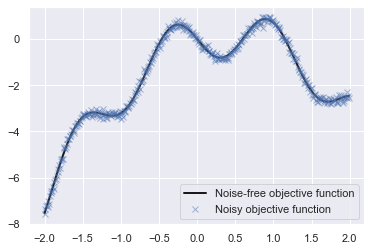

In [6]:
# --- Examine the objective function

# Preparations
dX = 0.01
X = np.arange(domain['min'], domain['max'], dX).reshape(-1, 1)

# Compute noise-free objective function
Y = f(X, 0)

# Generate noisy objective function
Y_noisy = f(X, noise)

# Plot objective function
plt.plot(X, Y, 'k-', label='Noise-free objective function', lw=2)
plt.plot(X, Y_noisy, 'bx', label='Noisy objective function', alpha=0.5)
plt.legend()

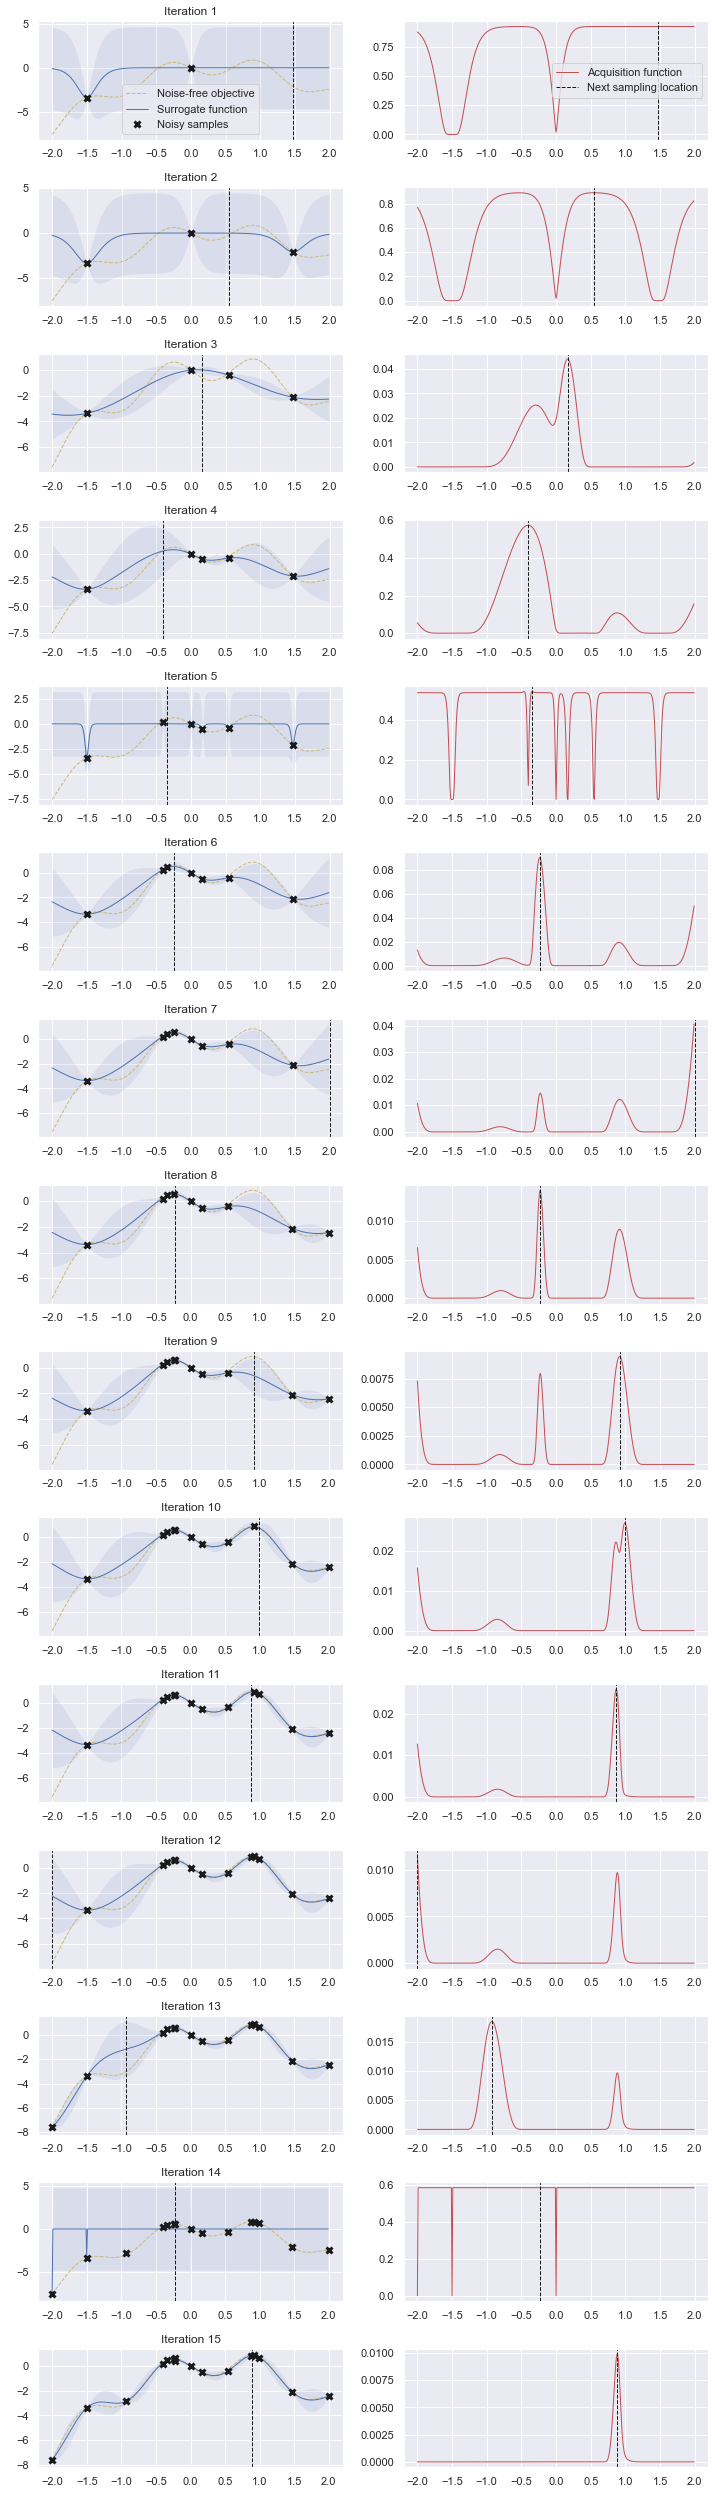

In [7]:
# --- Run Bayesian optimization

# Gaussian process with Matern kernel as surrogate model
m52 = ConstantKernel(1.0) * Matern(length_scale=1.0, nu=2.5)
gpr = GaussianProcessRegressor(kernel=m52, alpha=noise**2)

# Initialize samples
X_sample = np.array(X_init).reshape(-1, 1)
Y_sample = f(X_sample, noise=0)

plt.figure(figsize=(12, num_iterations * 3))
plt.subplots_adjust(hspace=0.4)

for i in tqdm(range(num_iterations), desc='Bayesian Optimization Iterations'):
    
    # Update surrogate function (Gaussian process) with existing samples
    gpr.fit(X_sample, Y_sample)

    # Obtain next sampling point from the acquisition function (expected_improvement)
    X_next = propose_location(compute_expected_improvement, domain, X_sample, Y_sample, gpr,
                              xi=xi)

    # Obtain next noisy sample from the objective function
    Y_next = f(X_next, noise)
    
    # Plot samples, surrogate function, noise-free objective and next sampling location
    plt.subplot(num_iterations, 2, 2 * i + 1)
    plot_approximation(gpr, X, Y, X_sample, Y_sample, X_next, show_legend=i==0)
    plt.title(f'Iteration {i+1}')

    plt.subplot(num_iterations, 2, 2 * i + 2)
    plot_acquisition(X, compute_expected_improvement(X, X_sample, Y_sample, gpr, xi=xi),
                     X_next, show_legend=i==0)
    
    # Add sample to previous samples
    X_sample = np.vstack((X_sample, X_next))
    Y_sample = np.vstack((Y_sample, Y_next))

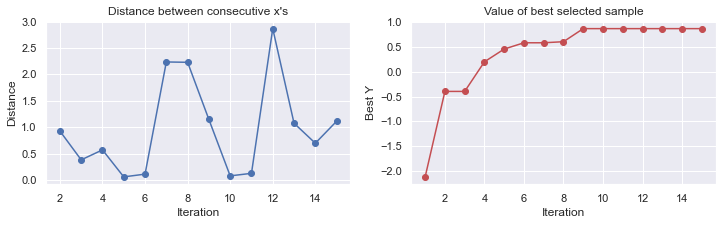

In [8]:
# --- Generate convergence plots

plot_convergence(X_sample, Y_sample)